In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [3]:
DATA_PATH = '/Users/mpekey/Desktop/FlyVideo/Peak_Signal_Data'

experiment_features = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

### Read Data

In [5]:
filename = os.path.join(DATA_PATH, 'bouts_dict.pkl')
with open(filename, 'rb') as f:
    bouts_dict = pickle.load(f)

true_peak_fn = os.path.join(DATA_PATH, 'true_peak_annotations.npy')
true_peak_df_fn = os.path.join(DATA_PATH, 'true_annotations.pkl')

true_peak_annotations_array = np.load(true_peak_fn)
with open(true_peak_df_fn, 'rb') as f:
    true_peak_annotations_df = pickle.load(f)

### Utils

In [6]:
def create_input_data(fly, experiment, features):
    
    input_data = bouts_dict[fly][features[0]][experiment].reshape(-1,1)

    for i in range(1, len(features)):
        input_data = np.concatenate((input_data,
                                    bouts_dict[fly][features[i]][experiment].reshape(-1,1)),
                                    axis=1)
    return input_data

class FlyInfo:
    def __init__(self, name, trial_id, peak_index, peak_values):
        self.name = name
        self.trial_id = trial_id
        self.peak_index = peak_index
        self.peak_values = peak_values

class FlyDatabase:
    def __init__(self):
        self.fly_data = []

    def add_fly(self, fly_info):
        self.fly_data.append(fly_info)

    def get_fly(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                return fly_info
        return None
    
    def write_fly_info(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                print('Name:', fly_info.name)
                print('Trial Id:', fly_info.trial_id)
                print('Peak Index:', fly_info.peak_index)
                print('Peak Values:', fly_info.peak_values)
                return None
        print('Fly not found!!!')
        return None

### Fly Database

In [7]:
fly_db = FlyDatabase()

fly_names = true_peak_annotations_df['name'].unique()

for name in fly_names:
    trial_idxs = true_peak_annotations_df[true_peak_annotations_df['name'] == name]['trial_id'].unique().tolist()
    for idx in trial_idxs:
        peak_index = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['peak_index'].values
        peak_values = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['value'].values
        fly_db.add_fly(FlyInfo(name, idx, peak_index, peak_values))

### Calculating Feature Means

In [10]:
import random

validation_ratio = 0.2
all_flies = fly_db.fly_data
num_validation_samples = int(len(all_flies) * validation_ratio)
random.shuffle(all_flies)

train_data = all_flies[num_validation_samples:]
val_data = all_flies[:num_validation_samples]

In [15]:
print('Train Data:', len(train_data), 'Validation Data:', len(val_data))

Train Data: 373 Validation Data: 93


In [54]:
from scipy import stats
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

def normalize(arr):
    #return (arr - arr.min()) / (arr.max() - arr.min())
    return stats.zscore(arr)

train_feat_means = {}

for feat in experiment_features:
    train_feat_means[feat] = np.mean(flatten_list([normalize(np.array(bouts_dict[fly.name][feat][int(fly.trial_id)])) for fly in train_data]))

In [55]:
train_feat_means

{'pose.prob_x': -2.088613258339238e-17,
 'pose.prob_y': -8.133668521599439e-16,
 'distance.head-prob': 9.26308202960296e-17,
 'distance.origin-prob': 8.156692604762233e-16}

In [56]:
train_concat_feat = {}

for feat in experiment_features:
    all_feats = []
    for i, fly in enumerate(train_data):
        all_feats.extend(normalize(np.array(bouts_dict[fly.name][feat][int(fly.trial_id)])).tolist())
        if i != len(train_data) - 1:
            all_feats.extend([train_feat_means[feat]])
    train_concat_feat[feat] = np.array(all_feats)

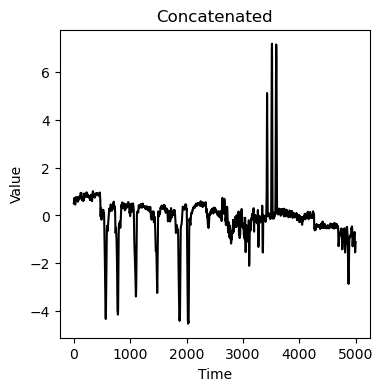

In [57]:
plt.figure(figsize=(4,4))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(train_concat_feat['distance.origin-prob'][:5000], color='black')
plt.title("Concatenated")
plt.show()

In [58]:
input_train_data = train_concat_feat[experiment_features[0]].reshape(-1, 1)

for i in range(1, len(experiment_features)):
    input_train_data = np.concatenate((input_train_data,
                                       train_concat_feat[experiment_features[i]].reshape(-1, 1)),
                                       axis=1)

print(input_train_data.shape)


(691655, 4)


In [59]:
input_val_data = []
for fly in val_data:
    input_val_data.append(
        np.concatenate((
            normalize(np.array(bouts_dict[fly.name][experiment_features[0]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[0]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[0]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[0]][int(fly.trial_id)])).reshape(-1,1)
        ),
        axis = 1))

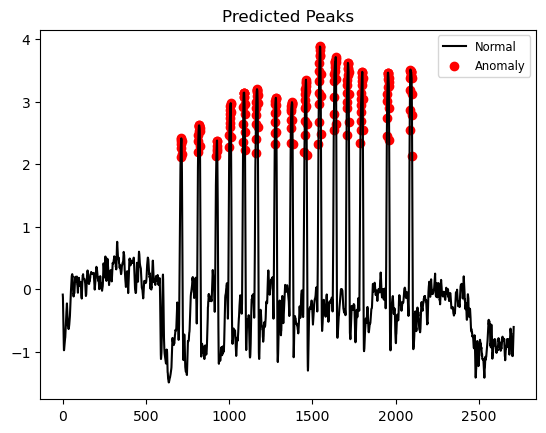

In [65]:
model = IsolationForest(n_estimators = 100,
                        contamination=0.04,
                        max_samples='auto',
                        max_features=1.0,
                        bootstrap=False)

model.fit(input_train_data)

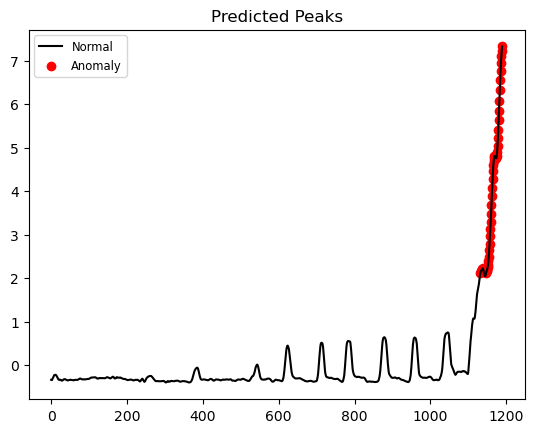

In [69]:
eval_df = pd.DataFrame(input_val_data[6], columns = experiment_features)
eval_df['predictions'] = model.predict(input_val_data[6])

anomalies = eval_df.loc[eval_df['predictions'] == -1, ['distance.origin-prob']]
plt.plot(eval_df.index, eval_df['distance.origin-prob'], color='black', label = 'Normal')
plt.scatter(anomalies.index, anomalies['distance.origin-prob'], color='red', label = 'Anomaly')
plt.title("Predicted Peaks")
plt.legend(fontsize='small')
plt.show()

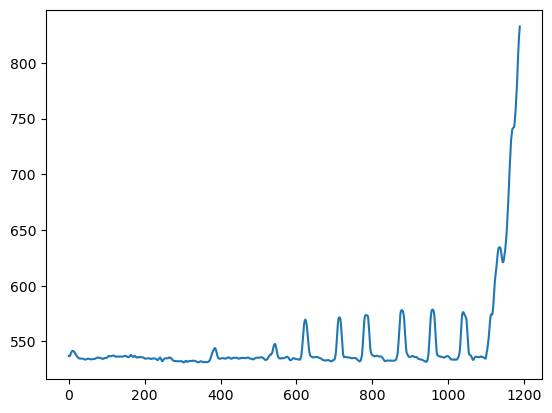

In [75]:
error_fly = val_data[6]

plt.plot(np.array(bouts_dict[error_fly.name]['distance.origin-prob'][int(error_fly.trial_id)]))
plt.show()